# Experiments

In [176]:
import numpy as np
import pandas as pd
from linear_data_load import *
from features import add_features
from submission import *
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data work

### Load

In [218]:
data_dir = '../rumoureval-2019-training-data'

In [219]:
a_train_data, a_dev_data, \
b_train_data, b_dev_data, data_struct = build_dataset(data_dir)

In [220]:
a_train_data.head()

,text,sqdc
501760642928635904,"[shows, michael, paid, cigarillos, robbery, cr...",3
500270212198174720,"[get, ready, tweet, address, #spikelee, vigila...",3
524971210275565568,"[radical, muslims, funded, american, senate, i...",3
552836882770690049,[kill],3
500289931097296897,"[would, require, reasoning, reasoning, applied...",0


In [221]:
b_train_data.head()

,text,support,deny,query,veracity
500288349924782080,"[anyone, think, comparing, clothes, #mikebrown...",0.461538,0.076923,0.000000,2.0
500308076004929537,"[possible, robbery, took, place, bam, like, ma...",0.000000,0.125000,0.125000,2.0
544282227035869184,"[breaking, news, gunmen, take, hostages, sydne...",0.400000,0.200000,0.000000,0.0
529695367680761856,"[omg, #prince, rumoured, performing, toronto, ...",0.000000,0.125000,0.125000,1.0
544324444773433348,"[uber, says, hiked, prices, sydney, encourage,...",0.238095,0.142857,0.047619,0.0


### Statistics

In [222]:
a_train_data.shape

(5217, 2)

In [223]:
b_train_data.shape

(374, 5)

In [224]:
b_dev_data.shape

(374, 5)

#### Concat populations

In [225]:
veracity_data = pd.concat([b_train_data, b_dev_data], axis=0)

In [226]:
veracity_data.shape

(748, 5)

In [227]:
stance_data = pd.concat([a_train_data, a_dev_data], axis=0)

In [228]:
stance_data.shape

(6664, 2)

#### Labels distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85328ffbe0>]],
      dtype=object)

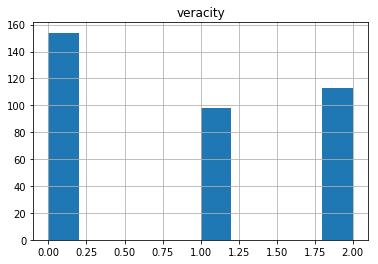

In [229]:
veracity_data.hist('veracity')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8532c5ebe0>]],
      dtype=object)

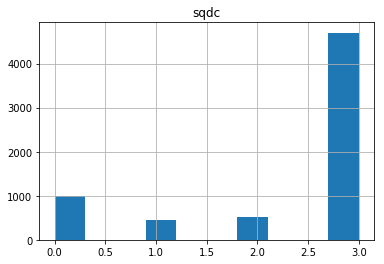

In [230]:
stance_data.hist('sqdc')

## Preprocessing

In [232]:
veracity_data

,text,support,deny,query,veracity
500288349924782080,"[anyone, think, comparing, clothes, #mikebrown...",0.461538,0.076923,0.000000,2.0
500308076004929537,"[possible, robbery, took, place, bam, like, ma...",0.000000,0.125000,0.125000,2.0
544282227035869184,"[breaking, news, gunmen, take, hostages, sydne...",0.400000,0.200000,0.000000,0.0
529695367680761856,"[omg, #prince, rumoured, performing, toronto, ...",0.000000,0.125000,0.125000,1.0
544324444773433348,"[uber, says, hiked, prices, sydney, encourage,...",0.238095,0.142857,0.047619,0.0
544350712365207552,"[#breaking, reports, two, customers, employee,...",0.666667,0.000000,0.333333,0.0
500389488217309184,"[#ferguson, chief, let, day, go, b4, disclosin...",0.186047,0.046512,0.232558,2.0
552806309540528128,"[#charliehebdo, cartoonists, charb, cabu, dead...",0.127273,0.036364,0.000000,1.0
552978099357237248,"[compelling, image, i've, seen, come, horrifyi...",0.666667,0.000000,0.000000,1.0
524956129017995264,"[police, say, shots, fired, 3, #ottawa, sites,...",0.100000,0.125000,0.000000,1.0
